### Librerías utilizadas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score,roc_auc_score, roc_curve
from sklearn.metrics import plot_confusion_matrix, f1_score

### Datos utilizados

Se importan los datos que resultaron del proceso de preparación de datos:

In [2]:
data = pd.read_csv('C:/Users/gusta/OneDrive/Documentos/Tesis/Datos/Datos_prep.csv') 

Se seleccionan las variables que serán utilizadas como variables dependientes, estas variables son las que cuentan con un buen IV para ser considerados en el modelo:

In [3]:
var_predictivas = ['CC','VFA','CC_GRAS','CC_MUSC','CC_HUES','CC_AGUA','PAS',
                   'PAM','PESO','PAD','TALLA','GLU','IMC']
X = data[var_predictivas] 
y = data['TARGET_HDL'] 

### Separación de datos

Para evaluar mejor el rendimiento del modelo, es una buena estrategia dividir el conjunto de datos dos: un conjunto de entrenamiento (70%) y uno de prueba (30%). Sin embargo, dado que la muestra de datos no esta balanceada (17.53% de Eventos vs 82.47% de No-Eventos) se hará primero un submuestreo (undersampling) el cual consiste en eliminar aleatoreamente algunos registros pertenecientes a la clase de No-Eventos (0).

In [4]:
print('Original dataset shape %s' % Counter(y))

Original dataset shape Counter({0: 1449, 1: 308})


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=19)
print('Train dataset shape %s' % Counter(y_train))
print('Test dataset shape %s' % Counter(y_test))

Train dataset shape Counter({0: 1154, 1: 251})
Test dataset shape Counter({0: 295, 1: 57})


In [6]:
#rus = RandomUnderSampler(random_state=1,sampling_strategy=0.25)
#X_train, y_train = rus.fit_resample(X_train, y_train)
#print('Resampled train dataset shape %s' % Counter(y_train))

In [7]:
ros = RandomOverSampler(random_state=19,sampling_strategy=0.5)
X_train, y_train = ros.fit_resample(X_train, y_train)
print('Resampled train dataset shape %s' % Counter(y_train))

Resampled train dataset shape Counter({0: 1154, 1: 577})


## Modelos supervisados para Clasificación

En esta sección se llevará a cabo la construcción de los modelos supervisados de Machine Learning que identifiquen si el paciente tiene su nivel de Colesterol HDL por debajo de los 40 mg/dL para posteriormente hacer la clasificación en Evento y No-Evento.

### Árbol de decisión

Se contruye un modelo de Árbol de Decisión usando Scikit-learn.

In [8]:
# Parámetros para el modelo
param_dict_tr= dict(criterion=['gini','entropy'], splitter=['best','random'],
                 max_depth=range(2,30), max_features=range(2,5),
                 max_leaf_nodes=range(5,35), min_samples_leaf=[0.05])

# Crear el objeto árbol de decisión para clasificación
tr_clf = DecisionTreeClassifier()

# Autotuning de los modelos
#grid_tr = GridSearchCV(cv=5, estimator=tr_clf, n_jobs=-1, 
#                     param_grid=param_dict_tr ,scoring='roc_auc')
#grid_tr.fit(X_train,y_train)
#tr_clf = grid_tr.best_estimator_

rsgrid_tr = RandomizedSearchCV(tr_clf, param_dict_tr, cv=20,
                                scoring='roc_auc', n_iter=40, n_jobs=-1)
rsgrid_tr.fit(X_train,y_train)
tr_clf = rsgrid_tr.best_estimator_

# Entrenar el árbol de decisión
tr_clf = tr_clf.fit(X_train,y_train)

In [9]:
# Los mejores parámetros
#grid_tr.best_estimator_
rsgrid_tr.best_estimator_

DecisionTreeClassifier(max_depth=12, max_features=3, max_leaf_nodes=20,
                       min_samples_leaf=0.05)

### Random Forest

Se contruye un modelo de Random Forest usando Scikit-learn.

In [10]:
# Parámetros para el modelo
param_dict_rf= dict(n_estimators=range(50,150), criterion=['entropy'],
                 max_depth=range(20,30), max_features=range(2,5),
                 max_leaf_nodes=range(5,20), min_samples_leaf=[0.05])

# Crear el objeto Random Forest para clasificación
rf_clf = RandomForestClassifier()

#Autotuning de los modelos
#grid_rf = GridSearchCV(cv=5, estimator=rf_clf, n_jobs=-1, 
#                     param_grid=param_dict_rf ,scoring='roc_auc')
#grid_rf.fit(X_train,y_train)
#rf_clf = grid_rf.best_estimator_

rsgrid_rf = RandomizedSearchCV(rf_clf, param_dict_rf, cv=20,
                                scoring='roc_auc', n_iter=40, n_jobs=-1)
rsgrid_rf.fit(X_train,y_train)
rf_clf = rsgrid_rf.best_estimator_

# Entrenar el Random Forest
rf_clf = rf_clf.fit(X_train,y_train)

In [11]:
# Los mejores parámetros
#grid_rf.best_estimator_
rsgrid_rf.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=24, max_features=4,
                       max_leaf_nodes=13, min_samples_leaf=0.05,
                       n_estimators=64)

### Gradient Boosting

Se contruye un modelo de Gradient Boosting usando Scikit-learn.

In [12]:
# Parámetros para el modelo
param_dict_gb= dict(criterion=['friedman_mse', 'mse', 'mae'], 
                    loss=['deviance','exponential'], 
                    learning_rate=[0.05,0.10,0.15,0.20,0.25,0.30,0.5,0.8,1],
                    max_depth=range(2,10), max_features=range(2,5),
                    max_leaf_nodes=range(5,35), min_samples_leaf=[0.05])

# Crear el objeto Gradient Boosting para clasificación
gb_clf = GradientBoostingClassifier()

#Autotuning de los modelos
#grid_gb = GridSearchCV(cv=5, estimator=gb_clf, n_jobs=-1, 
#                     param_grid=param_dict_gb ,scoring='roc_auc')
#grid_gb.fit(X_train,y_train)
#gb_clf = grid_gb.best_estimator_

rsgrid_gb = RandomizedSearchCV(gb_clf, param_dict_gb, cv=20,
                                scoring='roc_auc', n_iter=40, n_jobs=-1)
rsgrid_gb.fit(X_train,y_train)
gb_clf = rsgrid_gb.best_estimator_

# Entrenar el Gradient Boosting
gb_clf = gb_clf.fit(X_train,y_train)

In [13]:
# Los mejores parámetros
#grid_gb.best_estimator_
rsgrid_gb.best_estimator_

GradientBoostingClassifier(learning_rate=1, loss='exponential', max_depth=8,
                           max_features=3, max_leaf_nodes=19,
                           min_samples_leaf=0.05)

### XGBoost

Se contruye un modelo de XGBoost usando XGBoost.

In [14]:
# Parámetros para el modelo
param_dict_xgb= {'eta': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
                 'max_depth':[3,4,5,6,8,10,12,15],
                 'min_child_weight': [1,3,5,7],
                 'gamma': [0.0,0.1,0.2,0.3,0.4],
                 'colsample_bytree': [0.3,0.4,0.5,0.7],
                 'n_estimators': range(50,150)}

# Crear el objeto Gradient Boosting para clasificación
xgb_clf = XGBClassifier()

#Autotuning de los modelos
#grid_xgb = GridSearchCV(cv=5, estimator=xgb_clf, n_jobs=-1, 
#                     param_grid=param_dict_xgb ,scoring='roc_auc')
#grid_xgb.fit(X_train,y_train)
#xgb_clf = grid_xgb.best_estimator_

rsgrid_xgb = RandomizedSearchCV(xgb_clf, param_dict_xgb, cv=20,
                                scoring='roc_auc', n_iter=40, n_jobs=-1)
rsgrid_xgb.fit(X_train,y_train)
xgb_clf = rsgrid_xgb.best_estimator_

# Entrenar el Gradient Boosting
xgb_clf = xgb_clf.fit(X_train,y_train)

In [15]:
# Los mejores parámetros
#grid_xgb.best_estimator_
rsgrid_xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, eta=0.15, gamma=0.1,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.150000006, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=97, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Neural Network

Se contruye un modelo de Redes Neuronales usando Scikit-learn.

In [16]:
# Parámetros para el modelo
param_dict_mlp = dict(learning_rate=['constant', 'invscaling', 'adaptive'], 
                      momentum=[0.01, 0.1, 0.2, 0.5, 0.7, 0.9, 1],   #only when solver=sgd
                      activation=['identity', 'logistic', 'tanh', 'relu'],
                      solver=['lbfgs', 'sgd', 'adam'],
                      hidden_layer_sizes = range(3,30))

# Crear el objeto Neural Network para clasificación
mlp_clf = MLPClassifier()

#Autotuning de los modelos
#grid_mlp = GridSearchCV(cv=5, estimator=mlp_clf, n_jobs=-1, 
#                     param_grid=param_dict_mlp ,scoring='roc_auc')
#grid_mlp.fit(X_train,y_train)
#mlp_clf = grid_mlp.best_estimator_

rsgrid_mlp = RandomizedSearchCV(mlp_clf, param_dict_mlp, cv=20,
                                scoring='roc_auc', n_iter=40, n_jobs=-1)
rsgrid_mlp.fit(X_train,y_train)
mlp_clf = rsgrid_mlp.best_estimator_

# Entrenar la Neural Network
mlp_clf = mlp_clf.fit(X_train,y_train)

C:\Users\gusta\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [17]:
# Los mejores parámetros
#grid_mlp.best_estimator_
rsgrid_mlp.best_estimator_

MLPClassifier(activation='logistic', hidden_layer_sizes=25,
              learning_rate='invscaling')

### Estadísticos de precisión

A continuación, se muestra la curva ROC de cada uno de los modelos junto con estadístico AUC que indica el área debajo de la curva ROC.

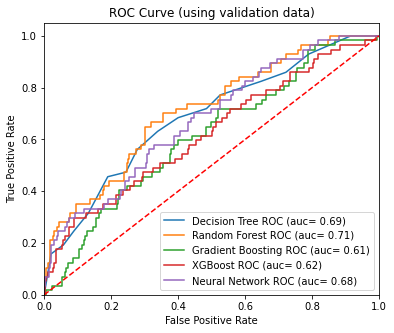

In [18]:
modelos = [{'label':'Decision Tree','modelo':tr_clf,},
           {'label':'Random Forest','modelo':rf_clf,},
           {'label':'Gradient Boosting','modelo':gb_clf,},
           {'label':'XGBoost','modelo':xgb_clf,},
           {'label':'Neural Network','modelo':mlp_clf,}]

plt.figure(figsize=(6,5))
for m in modelos:
    modelo = m['modelo']
    fpr, tpr, thresholds = roc_curve(y_test, modelo.predict_proba(X_test)[:,1])
    auc = roc_auc_score(y_true=y_test, y_score=modelo.predict_proba(X_test)[:,1])
    plt.plot(fpr,tpr,label='%s ROC (auc= %0.2f)' % (m['label'], auc))
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05]) 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (using validation data)')
plt.legend(loc="lower right")
plt.show()

Cambiar a explicación del estadístico F1

In [19]:
for m in modelos:
    modelo = m['modelo']
    f1= f1_score(y_test,modelo.predict(X_test),average='macro')
    print('%s F1 Score: %0.2f' % (m['label'], f1))

Decision Tree F1 Score: 0.59
Random Forest F1 Score: 0.63
Gradient Boosting F1 Score: 0.52
XGBoost F1 Score: 0.57
Neural Network F1 Score: 0.62


También se puede observar la matriz de confusión:

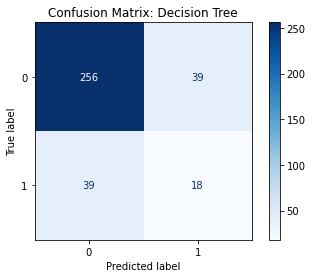

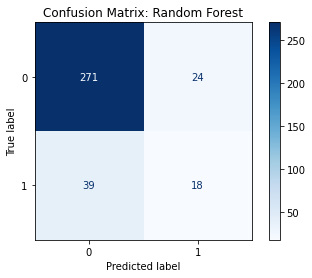

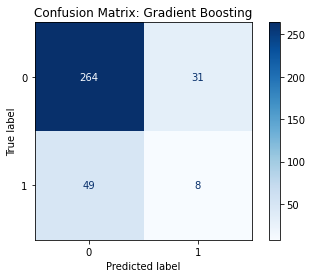

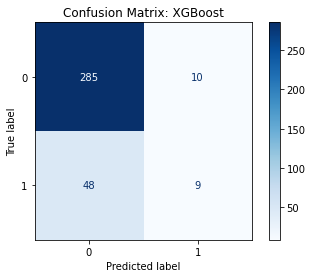

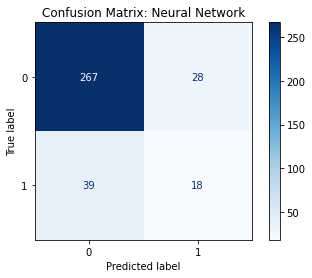

In [20]:
for m in modelos:
    modelo = m['modelo']
    disp = plot_confusion_matrix(modelo, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    disp.ax_.set_title('Confusion Matrix: %s' % (m['label']))

plt.show()